In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow import keras
from typing import Tuple
from keras.layers import MaxPool2D, Conv2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras import Sequential
from sklearn.metrics import auc, roc_curve
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

FILE_PATH_BASE = '/kaggle/input/histopathologic-cancer-detection'
TRAIN_FILES_PATH = f'{FILE_PATH_BASE}/train/'
TEST_FILES_PATH = f'{FILE_PATH_BASE}/test/'
TRAIN_LABELS_PATH = f'{FILE_PATH_BASE}/train_labels.csv'
TRAIN_FILES = os.listdir(TRAIN_FILES_PATH)
TEST_FILES = os.listdir(TEST_FILES_PATH)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Description of the project, data and objectives
This project main objective is to develop an algorithm that is able to identify metastatic cancer in small image patches taken from larger digital pathology scans. The performance of the model will be evaluated on the area under the ROC curve between the predicted probability and the observed target. The data is already divided into two separate folders:

1. Train data
2. Test data

And has a separate file with the true labels of the train data as a CSV file.

Here is the size and dimensions of the data:

In [2]:
n_samples_train = len(TRAIN_FILES)
n_samples_test = len(TEST_FILES)
image = plt.imread(f'{FILE_PATH_BASE}/train/{TRAIN_FILES[0]}')
print(image.shape)
print(f'Number of training images: {n_samples_train}')
print(f'Number of test images: {n_samples_test}')
print(f'Number of total images: {n_samples_train+n_samples_test}')

(96, 96, 3)
Number of training images: 220025
Number of test images: 57458
Number of total images: 277483


The dataset contains 277,483 total images, with 220,025 ($\approx$ 80%) images for training and 57,458 ($\approx$ 20%) images for testing. After loading one image we can see the dimensions are 96 X 96 X 3.

# EDA
Below there is a sample of pathology images that are positive and negative. After a brief research on how the images are classified by specialists(I am not one by any means), it seems that the main difference between them are the shape of the tissue in the tumors. If it has irregular shape and size, then this might indicate metastatic cancer. 

It is also important to note the following detail in the instruction: "A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image"

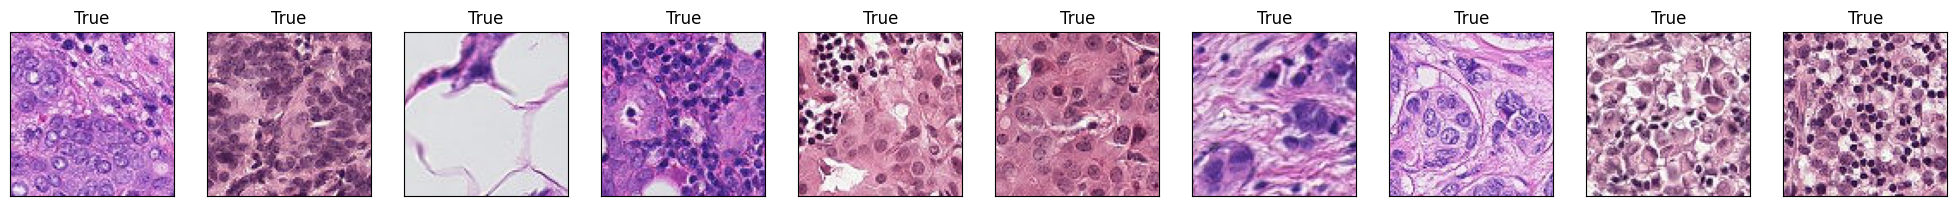

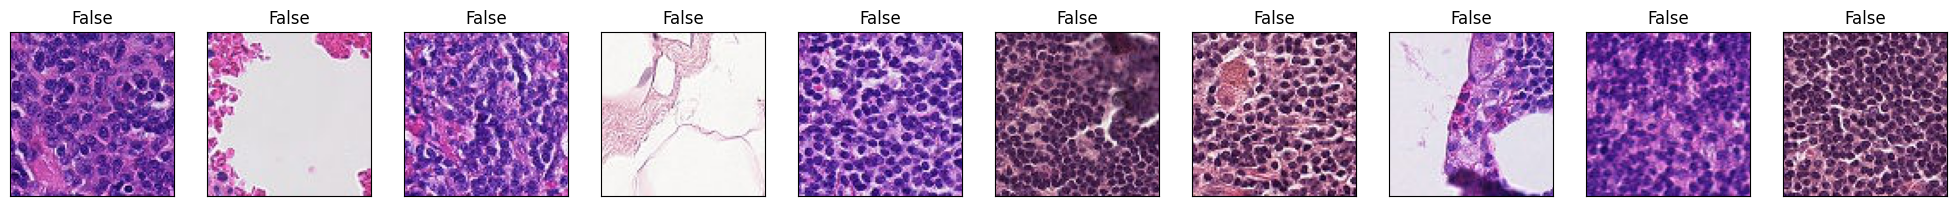

In [3]:
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH)
sample_true, sample_false = train_labels_df.query('label == 1').sample(10)['id'].values,train_labels_df.query('label == 0').sample(10)['id'].values
fig = plt.figure(figsize=(25, 4))
for idx, id_ in enumerate(sample_true):
    ax = fig.add_subplot(1, 10, idx + 1, xticks=[], yticks=[])
    ax.set_title('True')
    p = f'{FILE_PATH_BASE}/train/{id_}.tif'
    im = Image.open(p)
    plt.imshow(im)
fig = plt.figure(figsize=(25, 4))
for idx, id_ in enumerate(sample_false):
    ax = fig.add_subplot(1, 10, idx + 1, xticks=[], yticks=[])
    ax.set_title('False')
    p = f'{FILE_PATH_BASE}/train/{id_}.tif'
    im = Image.open(p)
    plt.imshow(im)

False counts: 130908, True counts: 89117, Imbalance Ratio: 1.47


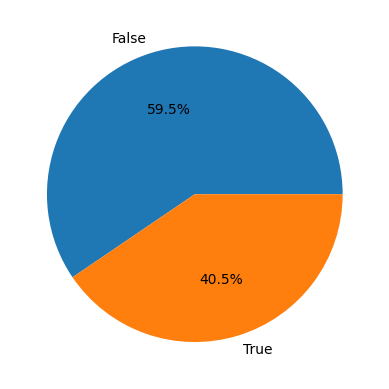

In [4]:
counts = train_labels_df.label.value_counts()
f_counts, t_counts = counts
print(f'False counts: {f_counts},',f'True counts: {t_counts},', f'Imbalance Ratio: {round(f_counts/t_counts,2)}')
fig, ax = plt.subplots()
ax.pie(counts, labels=['False', 'True'], autopct='%1.1f%%')
plt.show()

The dataset is imbalanced, it will be best to try to balance it. 

The plan for the analysis and the architecture will be the following.
* Further separate the training dataset, into training and validation (80-20) split.
* Balance the dataset
* Use a convolutional neuron network to compress the images
* Tweak hyperparameters such as the number of filters, number of layers, activation functions, loss function and learning rate
* Compute the chart for the loss of training vs validation over EPOCH's
* Predict test data and get the results.

False counts: 89117, True counts: 89117, Imbalance Ratio: 1.0


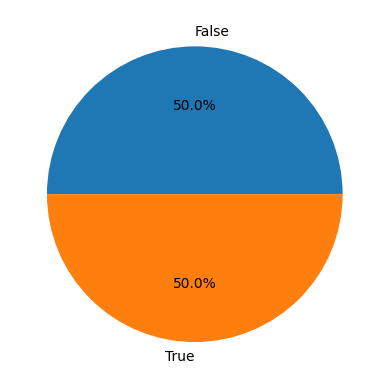

In [5]:
train_labels_df_balanced = pd.concat([train_labels_df[train_labels_df.label == 1], train_labels_df[train_labels_df.label == 0].sample(89117)])
counts = train_labels_df_balanced.label.value_counts()
train_labels_df_balanced = train_labels_df.sample(frac=1)
f_counts, t_counts = counts
print(f'False counts: {f_counts},',f'True counts: {t_counts},', f'Imbalance Ratio: {round(f_counts/t_counts,2)}')
fig, ax = plt.subplots()
ax.pie(counts, labels=['False', 'True'], autopct='%1.1f%%')
plt.show()
train_labels_df_balanced.to_csv('/kaggle/working/balanced_train_labels.csv', index=False)
train_labels_df.to_csv('/kaggle/working/train_labels.csv', index=False)

In [6]:
class project_data:
    def __init__(self, train_path: str, test_path: str, csv_label_path: str, seed: int, batch_size: int = 32, validation_split = 0.2, target_size: Tuple[int,int] = (96,96), y_col: str = 'label'):
        self.batch_size = batch_size
        self.target_size = target_size
        self.y_col = y_col
        self.df_label_mapping = pd.read_csv(csv_label_path).assign(
            file_name = lambda df_: df_.id + '.tif',
        )
        self.df_label_mapping[y_col] = self.df_label_mapping[y_col].astype('str')
        self.df_test_mapping = pd.DataFrame([
            [f[:-4],f] for f in TEST_FILES #READING GLOBAL VARIABLE TO AVOID DUPLICATE LOAD
        ], columns = ['id','file_name'])
        image_gen = ImageDataGenerator(
            rescale= 1./255,
            validation_split= validation_split
        )
        self.train_generator = image_gen.flow_from_dataframe(
            dataframe=self.df_label_mapping,
            directory=train_path,
            x_col='file_name',
            y_col=y_col,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=True,
            seed=seed,
            subset='training'
        )
        self.validation_generator= image_gen.flow_from_dataframe(
            dataframe=self.df_label_mapping,
            directory=train_path,
            x_col='file_name',
            y_col=y_col,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=True,
            seed=seed,
            subset='validation'
        )
        self.test_generator = ImageDataGenerator(
            rescale= 1./255
        ).flow_from_dataframe(
            dataframe=self.df_test_mapping,
            directory=test_path,
            x_col='file_name',
            y_col=None,
            target_size=target_size,
            batch_size=batch_size*2,
            class_mode=None,
            color_mode='rgb',
            shuffle=False
        )

In [7]:
data = project_data(TRAIN_FILES_PATH, TEST_FILES_PATH, 'balanced_train_labels.csv', seed=2023)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


# Model Architecture
A Convolutional Neural Network seems like the best approach to use as a model.
I tried different architectures but the one that had the best performance has the following:
1. Three convolutional layers (convolutional layer, normalization, activation: relu, convolutional layer, normalization, activation: relu, max pool) with no. filters (32,64,96), kernels (3,3)
2. A densely connected neural network with 256 units
3. A final densenly connected network with a sigmoid activation function

I played around with different parameters like input size, number of filters, normalization, data augmentation (flips & rotations, etc), number of parameters, dropout, learning rate, optimization, epochs etc.

In [8]:
gpus = tf.config.list_logical_devices('GPU')
print("Number of available GPUs: ", len(gpus))
strategy = tf.distribute.MirroredStrategy(gpus)
#with tpu_strategy.scope():
with strategy.scope():
#if True:
    model = Sequential([
        Conv2D(data.batch_size, (3,3), input_shape=(96,96,3)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(data.batch_size, (3,3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(2,2),
        
        Conv2D(data.batch_size*2, (3,3)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(data.batch_size*2, (3,3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(2,2),
        
        Conv2D(data.batch_size*3, (3,3)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(data.batch_size*3, (3,3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(2,2),
        
        Flatten(),
        Dense(256, use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        
        Dense(1,activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(
    data.train_generator,
    epochs = 10,
    validation_data=data.validation_generator,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto', restore_best_weights=True),
        
    ]
)

Number of available GPUs:  1
Epoch 1/10
5501/5501 [==============================] - 2131s 385ms/step - loss: 0.3411 - accuracy: 0.8571 - val_loss: 1.1024 - val_accuracy: 0.7353
Epoch 2/10
5501/5501 [==============================] - 607s 110ms/step - loss: 0.2383 - accuracy: 0.9069 - val_loss: 0.9235 - val_accuracy: 0.7793
Epoch 3/10
5501/5501 [==============================] - 454s 83ms/step - loss: 0.2048 - accuracy: 0.9227 - val_loss: 0.2357 - val_accuracy: 0.9049
Epoch 4/10
5501/5501 [==============================] - 466s 85ms/step - loss: 0.1827 - accuracy: 0.9318 - val_loss: 0.2146 - val_accuracy: 0.9106
Epoch 5/10
5501/5501 [==============================] - 460s 83ms/step - loss: 0.1668 - accuracy: 0.9378 - val_loss: 0.3647 - val_accuracy: 0.8696
Epoch 6/10
5501/5501 [==============================] - 465s 85ms/step - loss: 0.1512 - accuracy: 0.9441 - val_loss: 0.1633 - val_accuracy: 0.9379
Epoch 7/10
5501/5501 [==============================] - 474s 86ms/step - loss: 0.1377 

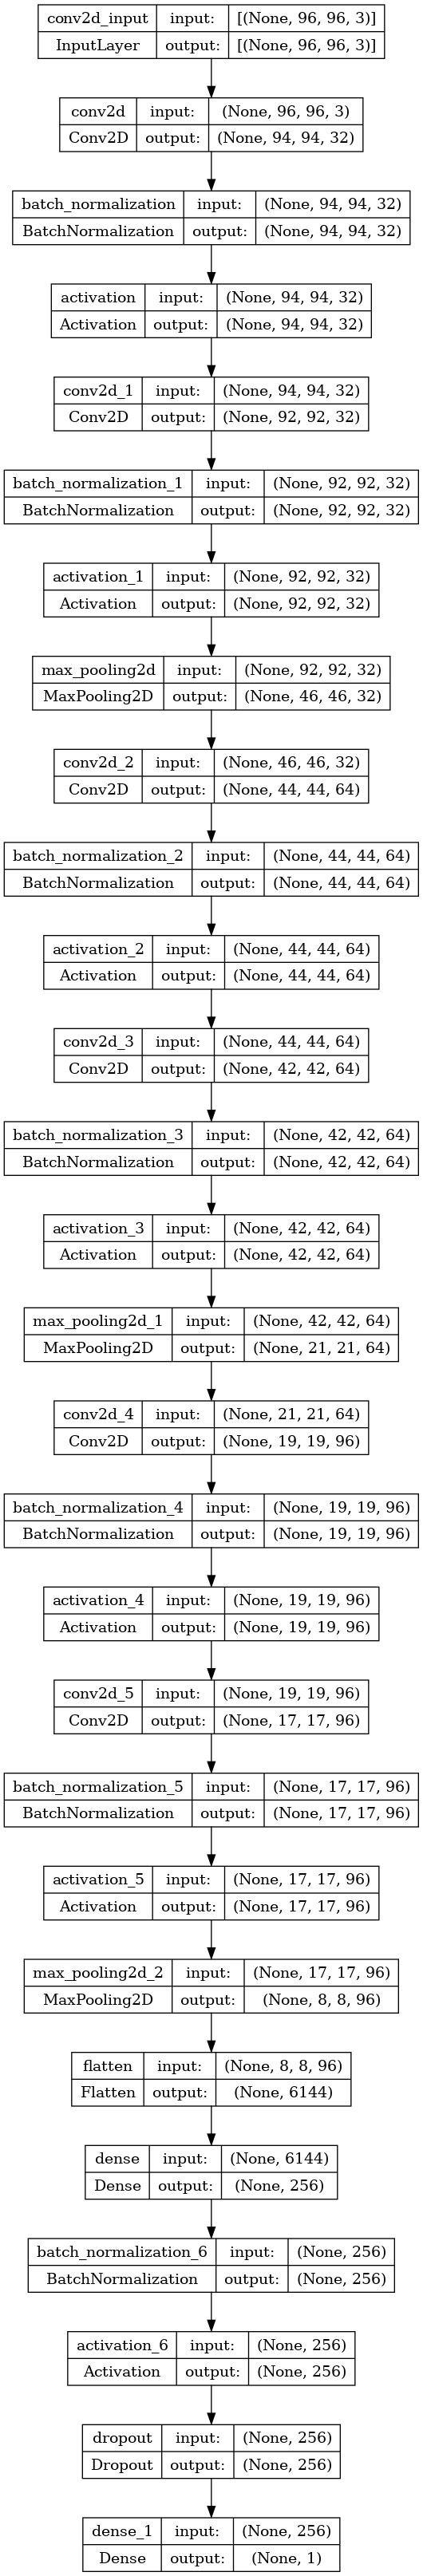

In [9]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
display(Image.open('model.png'))

# Model Validation

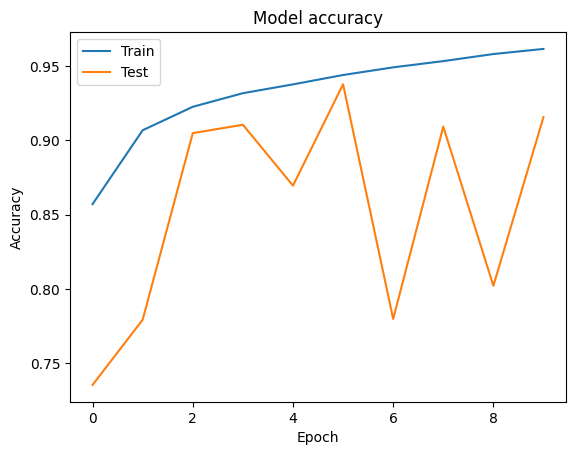

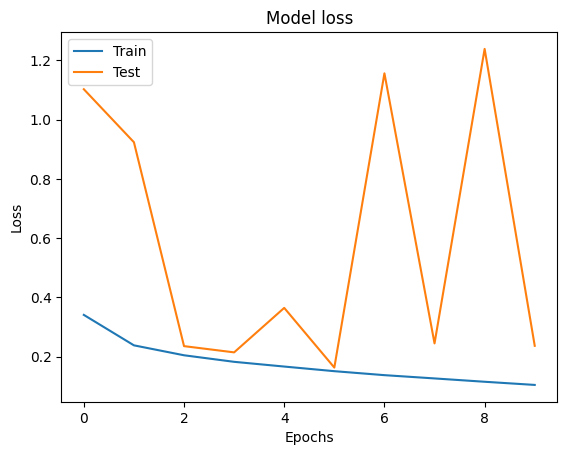

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
test_results = model.predict(data.test_generator)
test_labels = np.round(np.where(test_results > 0.5, 1, 0).flatten()).astype(int)
df = data.df_test_mapping[['id']]
df["label"] = test_labels
df.to_csv('/kaggle/working/final_result.csv', index=False)
pd.read_csv('/kaggle/working/final_result.csv')

898/898 [==============================] - 526s 585ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,0
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,1
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,0


# Results, Analysis and Conclusion
After a lot of playing with hyperparamaeters this is the best result I managed to get with a private/public score of (0.858, 0.8907). 

It seems the model overfits the data, and working with dropoff layers, early stopping and reducing the learning rate with tensorflow callbacks did not improve my results.

One of the difficulties I encountered was to work in batches with the tensorflow library, perhaps working with pytorch would have been easier. Balancing the dataset improved a little bit, and probably I could also tweak the model to include more layers, but working with restricted resources in Kaggle took a long time to tune epochs, learning rates, etc.